# Построение решения с использованием суперпозиции для переменного дебита 
Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.2 от 20.10.2021

Хабибуллин Ринат 2021 г.

---
[Открыть на google colab](https://colab.research.google.com/github/khabibullinra/welltest_examples/blob/master/jupyter/18_superposition_variable_rate.ipynb)

# Содержание


In [1]:
# для того, чтобы скрипты гладко работали на https://colab.research.google.com/ пропишем
# установку библиотеки welltest
# библиотека welltest загружает определения функций для безразмерных переменных
# а также грузит anaflow которая обеспечивает работу с обратным преобразованием Лапласа

!pip install welltest

In [2]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

from welltest.functions import *

In [1]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    # при расчете убедимся, что td=0 не повлияет на расчет, даже если td массив и нулевой только один элемент
    return np.multiply(-0.5, expi(np.divide(-rd**2 / 4 , td, out=np.zeros_like(td), where=td!=0)), 
                     out=np.zeros_like(td), where=td!=0)

In [ ]:
p = pd_ei(td, rd=1) + pd_ei(td, rd = 2*r_ed)

# Расчет кривой восстановления давления

Один из самых простых примеров применения суперпозиции. Предполагаем, что добывающая скважина в однородном изотропном пласте запускается в момент времени `t=0` и работает `t_p_hr` часов, после чего останавливается. После остановки скважины забойное давление растет - и мы получим кривую восстановления давления.

Пусть решение задачи запуска скважины (падения давления) будет $P_d(t_d, r_d)$. Тогда решение для изменения давления при запуске и последующей остановки скважины можно представить в виде 
$$P_{bu.d}(t_d, t_{prod.d}) = P_d(t_d) - P_d(t_d-t_{prod.d}) \cdot \mathcal{H}(t_d-t_{prod.d})$$

где
* $t_d$ - безразмерное время после запуска скважины,
* $t_{prod.d}$ - безразмерное время работы скважины после запуска
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0) (в некоторых книгах обозначается как $\theta$)
* $P_d(t_d, r_d)$ - безразмерное давление - решение задачи запуска скважины (падения давления)
* $P_{bu.d}(t_d, r_d)$ - безразмерное давление- решение задачи запуска скважины и последующей остановки скважины

Функция Хевисайда

$$ \mathcal{H} = \begin{cases}0 & x < 0\\1 & x = 0\\1 & x > 0\end{cases}$$

В формуле опущен радиус - так как решение будет верно для любых значений радиуса, в том числе для $r_d=1$, что соответвует давлению на забое скважины

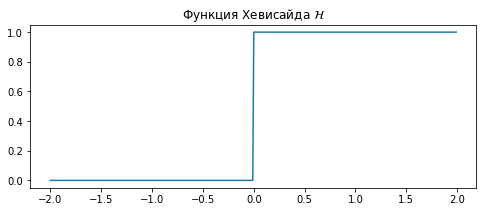

In [4]:
x = np.arange(-2,2,0.01)
y = np.heaviside(x, 1)

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(x,y)
plt.title('Функция Хевисайда $\mathcal{H}$ ')
plt.show()

In [5]:
def pd_build_up(td, td_p):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    """

    return pd_ei(td) - np.heaviside(td-td_p,1) * pd_ei(td-td_p)
    

In [6]:
t_arr = np.arange(1e-3, 48, 1e-2)
t_prod_hr = 24
k = 10   # проницаемость
q = 30   # дебит

# переведем размерный массив времени в безразмерные величины
td_arr = td_from_t(t_arr, k_mD=k)
td_prod = td_from_t(t_prod_hr, k_mD=k)
print('время работы скважины {:.2f} часа, что соответсвует безразмерному времени {:.2f}'.format(t_prod_hr, td_prod))

время работы скважины 24.00 часа, что соответсвует безразмерному времени 4320000.00


In [7]:
# для заданного массива безразмерных времен рассчитаем безразмерные давления
pd_arr = pd_build_up(td_arr, td_prod)

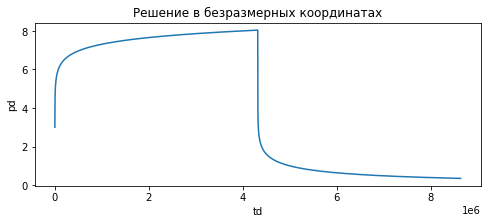

In [8]:
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(td_arr, pd_arr)
plt.xlabel('td')
plt.ylabel('pd')
plt.title('Решение в безразмерных координатах')
plt.show()

In [9]:
# переведем безразмерные координаты в размерные
p_arr = p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q)

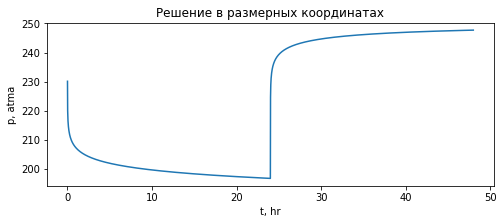

In [10]:
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(t_arr, p_arr)
plt.xlabel('t, hr')
plt.ylabel('p, atma')
plt.title('Решение в размерных координатах')
plt.show()

# Случай для произвольной истории дебитов

In [11]:
# создадим историю изменения дебитов 

t_history = np.array([ 0., 2., 24. ], dtype=np.float64) 
q_history = np.array([10., 5., 0.], dtype=np.float64)

# массивы должны быть одной и той же длины

Для расчета изменения давления при переменном дебите введем произвольное референсное значение дебита q_{ref} (например первое не нулевое значение дебита при запуске скважины). Используем это значение для определения безразмерного давления.
$$ p_D = \frac{kh}{ 18.41 q_{ref} B \mu} \left( p_i - p \right) $$

Тогда, используя принцип суперпозиции, можем выписать выражение для изменения давления на скважине и вокруг нее для произвольного момента времени

$$P_{mr.D} = \sum_i \frac{q_{i}-q_{i-1}}{q_{ref}} p_D\left(t-t_i\right)\cdot \mathcal{H}(t-t_i)$$

где

* $i$ - индекс значения дебита в таблице изменения дебитов
* $q_i$ - дебит с номером $i$, который стартует в момент времени $t_i$. Для первого момента времени $i$ дебит следующий перед ним считается равным нулю
* $t_i$ - момент времени с номером $i$
* $\mathcal{H}$ - ступенчатая [функция Хевисайда]
* $p_D$ - безразмерное давление - решение задачи запуска скважины (падения давления)

In [17]:
def p_superposition_atma(t_hr, t_hist_hr, q_hist_sm3day):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qh = np.hstack([0, q_hist_sm3day])
    th = np.hstack([0, t_hist_hr])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_q = np.hstack([0, np.diff(qh)])
    # зададимся каким нибудь дебитом как референсным
    q_ref = np.max(delta_q)
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    q, t =np.meshgrid(delta_q/q_ref, t_hr)
    dp = np.cumsum(q * pd_ei(td_from_t(t - th))* np.heaviside(td_from_t(t - th), 1),1 )

    return p_from_pd_atma(dp[:,-1], q_sm3day = q_ref)

def interpolate_constant(x, xp, yp):
    indices = np.searchsorted(xp, x, side='right')
    y = np.concatenate(([0], yp))
    return y[indices]

def q_superposition_sm3day(t_hr, t_hist_hr, q_hist_sm3day):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    q=[]
    for ti in t_hr:
        q.append(interpolate_constant(ti, t_hist_hr, q_hist_sm3day))
    return q

In [18]:
q_superposition_sm3day([1,2], t_history, q_history)

[10, 11]

In [19]:
p_superposition_atma(np.array([1,2]), t_history, q_history)

array([235.73984352, 234.97419391])

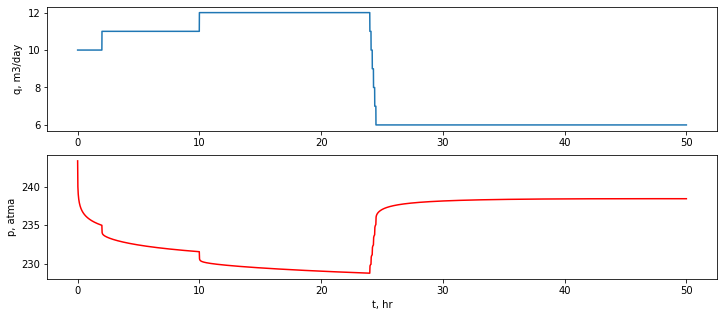

In [20]:
t_arr = np.arange(1e-3, 50, 1e-2)
plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition_sm3day(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

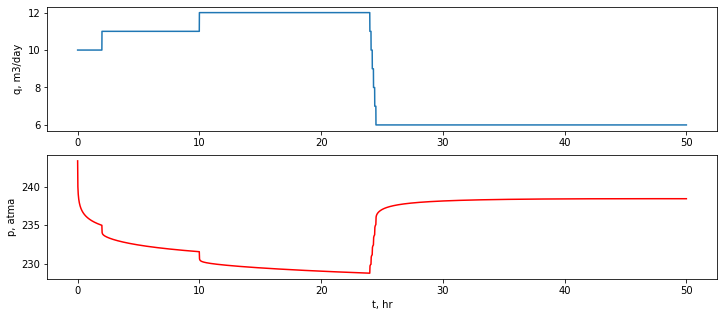

In [16]:

t_history = [0, 2, 10, 24, 24.1,24.2,24.3,24.4,24.5 ]
q_history = [10,11, 12,11,10,9,8,7, 6]

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition_sm3day(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()